# Click "Edit App" to see the code
# Least squares fitting 
In this tutorial we'll learn how to fit a function using the **lmfit** library, which provides an interface to non-linear fitting fitting routines.
Let's consider a set of $N$ observations $(x_{i},y_{i})$, where $x_i$ is the independent variable, $y_i$
is the dependent variable and $i=1,\dots,N$, and let $f(x)$ be fitting function that contains a number of parameters, $p_j$, which is much smaller than the number of observations.

The optimisation of the $p_j$ parameters is done via the minimisation of the sum of the square of the residuals, $r_i$, where the residuals are the differences between observed values, $y_i$, and the values provided by the fitting model, $f_i$

\begin{equation}
S = \sum_i r_i = [f(x_i) - y_i]^2 \tag{1}
\end{equation}

As an illustrative example of how the fitting works, we'll use a set of rate constants measured at different temperatures, which obey the Arrhenius equation

\begin{equation}
k_r = A\exp\bigg[-\frac{E_a}{RT}\bigg] \tag{2}
\end{equation}

The Arrhenius equation is often written in linear form ($y=mx+q$) by taking the logarithm of both sides of the equation

\begin{equation}
\ln\big[k_r\big] = \ln A -\frac{E_a}{R}\frac{1}{T} \tag{3}
\end{equation}

where $y=\ln[k_r]$ and $x=1/T$.

In order to show the limitations of the least square method, we'll fit the same data set using both an exponential and a linear function.

# The Jupyter notebook
As always we start by loading up the packages we will need.

In [1]:
# python packages
import pandas as pd # Dataframes and reading CSV files
import numpy as np # Numerical libraries
import matplotlib.pyplot as plt # Plotting library

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from lmfit import Model # Least squares fitting library

Then we read the data set from a file and cast it into a DataFrame, and we rename the columns.

In [2]:
data = pd.read_csv("../miscData/arrhenius.csv")
data.columns = ("T","Kr")
print(data)

             T         Kr
0   286.935975   0.000007
1   279.663719   0.000002
2   392.377962   0.285116
3   377.293693   0.065140
4   443.069616  10.248776
..         ...        ...
95  331.286178   0.001749
96  317.599848   0.000254
97  455.583233  15.167723
98  374.578390   0.047258
99  425.418873   3.568459

[100 rows x 2 columns]


As you may have noticed, the temperatures are not increasing (or decreasing) monotonically. 
Although this is not a problem for the fitting itself, we sort the DataFrame to make a nicer plot later.
We also reset the row indices, so that we can access the sorted temperature using the reordered indices of the DataFrame, if needed.

In [3]:
data = data.sort_values("T")
data.reset_index(drop=True, inplace=True)
print(data)

             T            Kr
0   274.244570  9.774365e-07
1   279.176951  1.822114e-06
2   279.663719  1.792565e-06
3   280.953971  2.611673e-06
4   281.624879  3.245136e-06
..         ...           ...
95  461.605672  2.605836e+01
96  464.692002  2.187696e+01
97  465.568587  2.207841e+01
98  469.974653  4.881751e+01
99  472.257602  4.154694e+01

[100 rows x 2 columns]


Although there are pre-built models, we assume that we are fitting a generic user-defined function. 
Hence, we need to define two functions for the two equations that we want to use for the fitting.

In [4]:
R = 8.314 # ideal gas constant in J/mol/K
def arrExp(x,A,Ea):
    return A * np.exp(-Ea/R/x)

def arrLin(x,lnA,Ea):
    return lnA - Ea/R * (1/x)

Neither the _scipy.optimize_ nor the _lmfit_ libraries compute the $R^2$, but we can easily do that using its definition.

\begin{equation}
R^2 = 1 - \frac{\sum_i (y_i-f_i)}{\sum_i(y_i-\langle y \rangle)^2}
\end{equation}

where the numerator is the sum of the residuals and the denominator is the variance, _i.e._ the standard deviation squared. The sum of the residuals is already computed by _lmfit_ and we can obtain the variance from NumPy.
The $R^2$ confirms that the linear fit it better.

# Fitting using curve_fit from SCIPY

Fitting a function to a dataset is fairly straightforward using the _curve_fit_ function.
This function provides two outputs, the parameters that give the best fit (_popt_) and the covariance matrix (_pcov_), which can be used to compute the error and $R^2$ score.

In [5]:
popt_exp, pcov_exp = curve_fit(arrExp,data["T"],data["Kr"])
popt_lin, pcov_lin = curve_fit(arrLin,data["T"],np.log(data["Kr"]))

We now compute the error on the best fit parameters $\dots$ 

In [6]:
pError_exp = np.sqrt(np.diag(pcov_exp))
pError_lin = np.sqrt(np.diag(pcov_lin))

$\dots$ and the $R^2$ score

In [7]:
y2_exp = arrExp(data["T"], *popt_exp)
Rsquared_exp = r2_score(data["Kr"], y2_exp)

y2_lin = arrLin(data["T"], *popt_lin)
Rsquared_lin = r2_score(np.log(data["Kr"]), y2_lin)

We now print the result of the exponential and linear fits.
* Note how much smaller the error on the activation energy is when using a linear fit.

In [8]:
print("----- Exponential fit -----")
print("A  parameter - Slope     = %8.3e +/- %.3e" % (popt_exp[0],pError_exp[0]))
print("Ea parameter - Intercept = %8.3f +/- %.3f" % (popt_exp[1],pError_exp[1]))
print("R squared                = %.4f" % Rsquared_exp)

print("----- Linear fit -----")
print("lnA parameter - Slope     = %8.3e +/- %.3e" % (popt_lin[0],pError_lin[0]))
print("Ea  parameter - Intercept = %8.3f +/- %.3f" % (popt_lin[1],pError_lin[1]))
print("R squared               = %.4f" % Rsquared_lin)

----- Exponential fit -----
A  parameter - Slope     = 4.844e+11 +/- 5.416e+11
Ea parameter - Intercept = 90901.293 +/- 4292.037
R squared                = 0.9349
----- Linear fit -----
lnA parameter - Slope     = 2.830e+01 +/- 1.833e-01
Ea  parameter - Intercept = 96424.791 +/- 544.122
R squared               = 0.9969


# Fitting using LMFIT

We then create two _Models_ objects using the *lmfit* library for the two independent fits.
* Note how we called the **Model** function directly, even if it is part of *lmfit* library. That is because the way we imported the library in the header. This implies that we cannot call any variable "Model".

In [9]:
modExp = Model(arrExp)
modLin = Model(arrLin)

Like all fitting procedures, *lmfit* requires a starting set of parameters to operate, that can be set by the user. The closer the parameters are to the correct ones the better the library will work. Typically the frequency factor is of the order of $10^{12}-10^{15}\ Hz$ and the activation energy for a slow-ish reaction is in the $1-100\ kJ/mol$ range.

In [10]:
paramsExp = modExp.make_params(A=1e13 , Ea=5)
paramsLin = modLin.make_params(lnA=np.log(1e13) , Ea=5)

We can now fit the data. The **fit** function takes three main arguments, $y$, the initial parameters and the $x$ of the data to fit. 
* Note how for the linear fit we pass to the _lmfit_ function the log of the rate but not the inverse of the temperature. This is because of the way we defined the **arrLin** function.

In [11]:
fitExp = modExp.fit(data["Kr"], paramsExp, x=data["T"])
fitLin = modLin.fit(np.log(data["Kr"]), paramsLin, x=data["T"])

We can now compute the $R^2$ score.

In [12]:
expR2 = 1 - fitExp.residual.var() / np.var(data["Kr"])
linR2 = 1 - fitLin.residual.var() / np.var(data["Kr"])

We can then print the result of the exponential and linear fits.
Note that the results are essentially identical to those obtained from _curve_fit_ because the same minimisation algorithm has been used.

In [13]:
print("----- Exponential fit -----")
print("A  parameter - Slope     = %8.3e +/- %.3e" % (fitExp.params["A"].value,
                                                     fitExp.params["A"].stderr))
print("Ea parameter - Intercept = %8.3f +/- %.3f" % (fitExp.params["Ea"].value,
                                                     fitExp.params["Ea"].stderr))
print("R squared                = %.4f" % expR2)

print("----- Linear fit -----")
print("lnA parameter - Slope     = %8.3e +/- %.3e" % (fitLin.params["lnA"].value,
                                                      fitLin.params["lnA"].stderr))
print("Ea  parameter - Intercept = %8.3f +/- %.3f" % (fitLin.params["Ea"].value,
                                                      fitLin.params["Ea"].stderr))
print("R squared               = %.4f" % linR2)

----- Exponential fit -----
A  parameter - Slope     = 4.844e+11 +/- 5.416e+11
Ea parameter - Intercept = 90901.298 +/- 4292.036
R squared                = 0.9349
----- Linear fit -----
lnA parameter - Slope     = 2.830e+01 +/- 1.833e-01
Ea  parameter - Intercept = 96424.791 +/- 544.122
R squared               = 0.9989


One advantage of _lmfit_ is that it also provides more extensive information of the fitting. 
For example for the exponential fit we have

In [14]:
fitExp.result

$\dots$ and for the linear fit.

In [15]:
fitLin.result

Let's now see how the two fits compare with the input data graphically by plotting the data and fit functions.
_lmfit_ has already computed the values of best fit, so there's nothing for us to do.
Note that for the linear fit we took the exponential of the data.

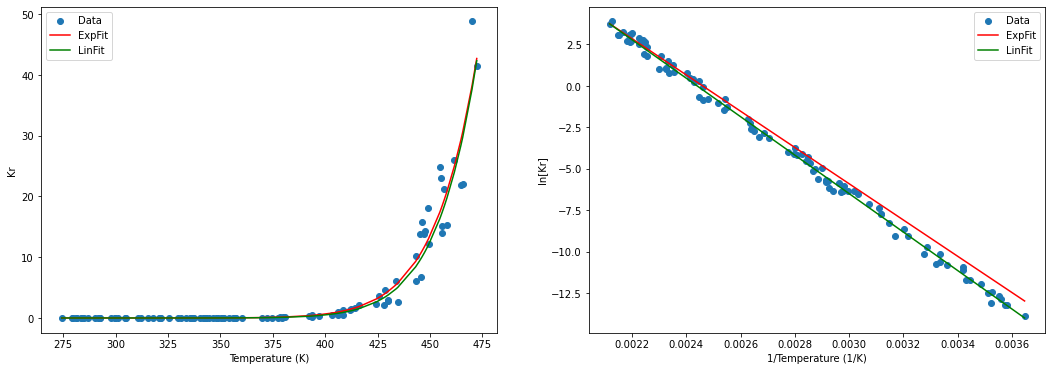

In [16]:
fig , ax = plt.subplots(1,2,figsize=(18,6))

ax[0].scatter(data["T"],data["Kr"],label="Data")
ax[0].plot(data["T"],fitExp.best_fit,label="ExpFit",color='red')
ax[0].plot(data["T"],np.exp(fitLin.best_fit),label="LinFit",color='green')
ax[0].set(xlabel="Temperature (K)")
ax[0].set(ylabel="Kr")
ax[0].legend()

ax[1].scatter(1/data["T"],np.log(data["Kr"]),label="Data")
ax[1].plot(1/data["T"],np.log(fitExp.best_fit),label="ExpFit",color='red')
ax[1].plot(1/data["T"],fitLin.best_fit,label="LinFit",color='green')
ax[1].set(xlabel="1/Temperature (1/K)")
ax[1].set(ylabel="ln[Kr]")
ax[1].legend()

plt.show()

Although both fits look good representations of the data when plotted in the exponential form, the linear fit appears clearly superior when the in the linear form.
This is due to fact that the least squares method minimises the residuals, so in the exponential form the tail of the function is _less_ important than the part with large numbers.